In [1]:
%matplotlib inline

In [2]:
# HACK: needed to manually import sys.path from ipython repl, for some reason it doesn't work on my host otherwise
import sys
sys.path = ['', '/Users/naveed/scratch/fraud_detection_project/venv/bin', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python27.zip', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-darwin', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-mac', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-tk', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-old', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-dynload', '/Users/naveed/anaconda2/lib/python2.7', '/Users/naveed/anaconda2/lib/python2.7/plat-darwin', '/Users/naveed/anaconda2/lib/python2.7/lib-tk', '/Users/naveed/anaconda2/lib/python2.7/plat-mac', '/Users/naveed/anaconda2/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/IPython/extensions', '/Users/naveed/.ipython']

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.set_option('max_colwidth', -1)

In [4]:
import xgboost

In [5]:
pdf = pd.read_csv('./creditcard.csv')

# Notes:
 - Reduced FeatureSet: 28 Features determined from prior PCA analysis. Original features were scrubbed for user anonymity
 - Time & Amount are the only two original features
 - Total Samples in DataSet: 284,807. Number of Fraudalent transactions: 492 (0.172%) of all transactions. Represented by "Class" Feature
 
# Goal:
 - with the highly imbalanced data set, normalize the data by normalizing  underfitting the data
 - compare different models and estimate which ones perform better
 - go back and use some oversampling method to see how the models change with the availability of more data
 - 

In [6]:
numerical_features_only = sorted(list(set(pdf.columns.tolist()) - set(['Time', 'Amount', 'Class'])), key=lambda x: int(x[1:]))

## Fraud Class EDA

In [7]:
fraud_df = pdf.loc[pdf.Class == 1]

In [51]:
fraud_df.describe()[['Amount']]

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


## Notes:
- using just the numerical variables, it seems that positive correlations exist between (8x9, 15-17), neg corr: (1-3, 18x15-17)

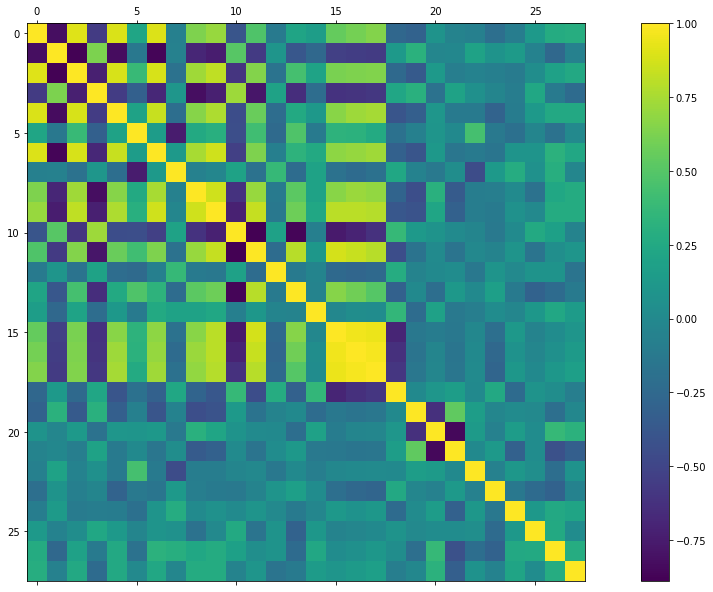

In [9]:
fig = plt.figure(figsize=(20,10))
cax = plt.matshow(fraud_df[numerical_features_only].corr(), fignum=1)
fig.colorbar(cax)

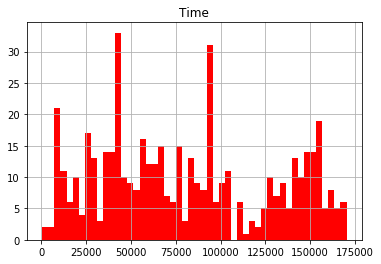

In [10]:
y = fraud_df[['Time']].hist(bins=50, color='red')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12054eb50>]],
      dtype=object)

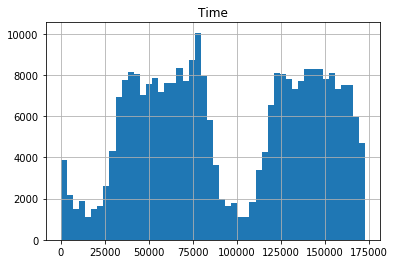

In [11]:
pdf[['Time']].hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1205fe390>]],
      dtype=object)

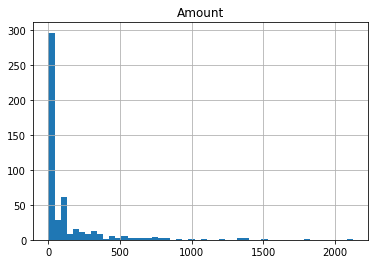

In [12]:
fraud_df[['Amount']].hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e0efd50>]],
      dtype=object)

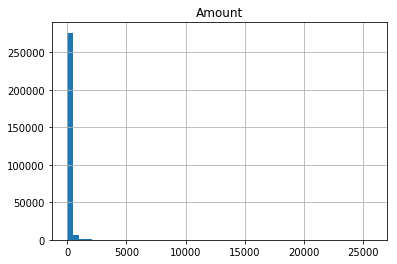

In [13]:
pdf[['Amount']].hist(bins=50)

## Data Preparation
- Dealing with imbalanced data seems to be a concern here because of the disparity of fraudalent data
    - Oversampling — SMOTE
    - Undersampling — RandomUnderSampler
    - Combined Class Methods — SMOTE + ENN
- Outlier Detection & Removal
- Dimensionality Reduction

In [14]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

pdf['time_normalized'] = normalize(pdf.Time)
pdf['amount_normalized'] = normalize(pdf.Amount)

In [15]:
def undersample(df):
    discriminant_feature = df.loc[df.Class == 1]
    cnt = len(discriminant_feature)
    other_set = df.loc[df.Class == 0].sample(n=cnt)
    
    together = pd.concat([discriminant_feature,other_set])
    return together.sample(frac=1)
    

balanced_df = undersample(pdf[numerical_features_only + ['time_normalized', 'amount_normalized', 'Class']])

### Split dataset into training / test

In [16]:
features = [x for x in balanced_df.columns.tolist() if x != 'Class']

X = balanced_df[features]
y = balanced_df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

In [17]:
results = pd.DataFrame()

col_order = ['false_negative', 'false_positive', 'true_negative', 'true_positive', 'fraud_f1-score', 'fraud_precision', 'fraud_recall', 'not_fraud_f1-score', 'not_fraud_precision', 'not_fraud_recall']

## Helper methods for model creation

In [18]:
def train_model(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {model_name} on test set: {accuracy:.2f}'.format(model_name=model_name, accuracy=model.score(X_test, y_test)))
    
    return y_pred

def flatten(report):
    "used to flatten confusion matrix and classification report "
    final_dict = {}
    for k, v in report.items():
        for k2, v2 in v.items():
            if k2 in ['precision', 'recall', 'f1-score'] and k in ['not_fraud', 'fraud']:
                final_dict[k + '_' +k2] =  v2
    
    return final_dict

def analyze_model_stats(model, model_name, X_train, X_test, y_train, y_test, y_pred, results_df):
    cfmx = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud'], output_dict=True)
    
    print 'CONFUSION MATRIX:\n',
    print(cfmx)
    print
    print 'CLASSIFICATION REPORT:'
    print(classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud']))
        
    data = dict({
        'name': model_name,
        'true_positive': cfmx[0,0],
        'false_negative': cfmx[0,1],
        'false_positive': cfmx[1,0],
        'true_negative': cfmx[1,1],
    }, **flatten(report))
    
    return [data]
    
def train_and_analyze(model, model_name, X_train, X_test, y_train, y_test, results_df):
    y_pred = train_model(model, model_name, X_train, X_test, y_train, y_test)
    return analyze_model_stats(model, model_name, X_train, X_test, y_train, y_test, y_pred, results_df)

## ML Models to try out
- [**DONE**] Logistic Regression
- [**DONE**] Linear Discriminant Analysis
- [**DONE**] K Nearest Neighbors (KNN)
- [**DONE**] Classification Trees (Decision Tree, Random Forest)
- [**DONE**]Support Vector Classifier
- [**DONE**] Random Forest Classifier
- [**DONE**] XGBoost Classifier (could not get this thing to compile -- try again later)

## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
results = results.append(train_and_analyze(logreg, 'logistic regression', X_train, X_test, y_train, y_test, results))

Accuracy of logistic regression on test set: 0.93
CONFUSION MATRIX:
[[372  23]
 [ 29 364]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.93      0.94      0.93       395
       fraud       0.94      0.93      0.93       393

   micro avg       0.93      0.93      0.93       788
   macro avg       0.93      0.93      0.93       788
weighted avg       0.93      0.93      0.93       788



/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,23,29,364,372,0.933333,0.940568,0.926209,0.934673,0.927681,0.941772


## Linear Discriminant Analysis

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [22]:
lindisc = LinearDiscriminantAnalysis()
results = results.append(train_and_analyze(lindisc, 'linear discriminant', X_train, X_test, y_train, y_test, results))

Accuracy of linear discriminant on test set: 0.90
CONFUSION MATRIX:
[[372  23]
 [ 56 337]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.87      0.94      0.90       395
       fraud       0.94      0.86      0.90       393

   micro avg       0.90      0.90      0.90       788
   macro avg       0.90      0.90      0.90       788
weighted avg       0.90      0.90      0.90       788



In [23]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,23,29,364,372,0.933333,0.940568,0.926209,0.934673,0.927681,0.941772
linear discriminant,23,56,337,372,0.895086,0.936111,0.857506,0.904010,0.869159,0.941772


## K Nearest Neighbors (KNN)

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
neigh = KNeighborsClassifier(n_neighbors=2)
results = results.append(train_and_analyze(neigh, 'k nearest neighbors', X_train, X_test, y_train, y_test, results))

Accuracy of k nearest neighbors on test set: 0.93
CONFUSION MATRIX:
[[385  10]
 [ 47 346]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.89      0.97      0.93       395
       fraud       0.97      0.88      0.92       393

   micro avg       0.93      0.93      0.93       788
   macro avg       0.93      0.93      0.93       788
weighted avg       0.93      0.93      0.93       788



In [26]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,23,29,364,372,0.933333,0.940568,0.926209,0.934673,0.927681,0.941772
linear discriminant,23,56,337,372,0.895086,0.936111,0.857506,0.904010,0.869159,0.941772
k nearest neighbors,10,47,346,385,0.923899,0.971910,0.880407,0.931076,0.891204,0.974684


## Classification Trees

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
dectree = DecisionTreeClassifier()
results = results.append(train_and_analyze(dectree, 'decision tree', X_train, X_test, y_train, y_test, results))

Accuracy of decision tree on test set: 0.92
CONFUSION MATRIX:
[[363  32]
 [ 34 359]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.91      0.92      0.92       395
       fraud       0.92      0.91      0.92       393

   micro avg       0.92      0.92      0.92       788
   macro avg       0.92      0.92      0.92       788
weighted avg       0.92      0.92      0.92       788



In [29]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,23,29,364,372,0.933333,0.940568,0.926209,0.934673,0.927681,0.941772
linear discriminant,23,56,337,372,0.895086,0.936111,0.857506,0.904010,0.869159,0.941772
k nearest neighbors,10,47,346,385,0.923899,0.971910,0.880407,0.931076,0.891204,0.974684
decision tree,32,34,359,363,0.915816,0.918159,0.913486,0.916667,0.914358,0.918987


## Support Vector Classification

In [30]:
from sklearn import svm

In [31]:
clf = svm.SVC(kernel='rbf', C=1, gamma=0.001, random_state=1)
results = results.append(train_and_analyze(clf, 'support vectors', X_train, X_test, y_train, y_test, results))

Accuracy of support vectors on test set: 0.92
CONFUSION MATRIX:
[[392   3]
 [ 63 330]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.86      0.99      0.92       395
       fraud       0.99      0.84      0.91       393

   micro avg       0.92      0.92      0.92       788
   macro avg       0.93      0.92      0.92       788
weighted avg       0.93      0.92      0.92       788



In [32]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,23,29,364,372,0.933333,0.940568,0.926209,0.934673,0.927681,0.941772
linear discriminant,23,56,337,372,0.895086,0.936111,0.857506,0.904010,0.869159,0.941772
k nearest neighbors,10,47,346,385,0.923899,0.971910,0.880407,0.931076,0.891204,0.974684
decision tree,32,34,359,363,0.915816,0.918159,0.913486,0.916667,0.914358,0.918987
support vectors,3,63,330,392,0.909091,0.990991,0.839695,0.922353,0.861538,0.992405


## Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rdm = RandomForestClassifier()
results = results.append(train_and_analyze(rdm, 'random forest', X_train, X_test, y_train, y_test, results))

Accuracy of random forest on test set: 0.93
CONFUSION MATRIX:
[[387   8]
 [ 49 344]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.89      0.98      0.93       395
       fraud       0.98      0.88      0.92       393

   micro avg       0.93      0.93      0.93       788
   macro avg       0.93      0.93      0.93       788
weighted avg       0.93      0.93      0.93       788



/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [35]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,23,29,364,372,0.933333,0.940568,0.926209,0.934673,0.927681,0.941772
linear discriminant,23,56,337,372,0.895086,0.936111,0.857506,0.904010,0.869159,0.941772
k nearest neighbors,10,47,346,385,0.923899,0.971910,0.880407,0.931076,0.891204,0.974684
decision tree,32,34,359,363,0.915816,0.918159,0.913486,0.916667,0.914358,0.918987
support vectors,3,63,330,392,0.909091,0.990991,0.839695,0.922353,0.861538,0.992405
random forest,8,49,344,387,0.923490,0.977273,0.875318,0.931408,0.887615,0.979747


## XGBoost Classifier

In [36]:
from xgboost import XGBClassifier

In [37]:
xgb = XGBClassifier()
results = results.append(train_and_analyze(xgb, 'XGBoost', X_train, X_test, y_train, y_test, results))

Accuracy of XGBoost on test set: 0.92
CONFUSION MATRIX:
[[371  24]
 [ 36 357]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.91      0.94      0.93       395
       fraud       0.94      0.91      0.92       393

   micro avg       0.92      0.92      0.92       788
   macro avg       0.92      0.92      0.92       788
weighted avg       0.92      0.92      0.92       788



In [38]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,23,29,364,372,0.933333,0.940568,0.926209,0.934673,0.927681,0.941772
linear discriminant,23,56,337,372,0.895086,0.936111,0.857506,0.904010,0.869159,0.941772
k nearest neighbors,10,47,346,385,0.923899,0.971910,0.880407,0.931076,0.891204,0.974684
decision tree,32,34,359,363,0.915816,0.918159,0.913486,0.916667,0.914358,0.918987
support vectors,3,63,330,392,0.909091,0.990991,0.839695,0.922353,0.861538,0.992405
random forest,8,49,344,387,0.923490,0.977273,0.875318,0.931408,0.887615,0.979747
XGBoost,24,36,357,371,0.922481,0.937008,0.908397,0.925187,0.911548,0.939241


In [41]:
blah = results.copy()
blah.set_index('name', inplace=True)
blah['false_negative_normalized'] = normalize(blah['false_negative'])

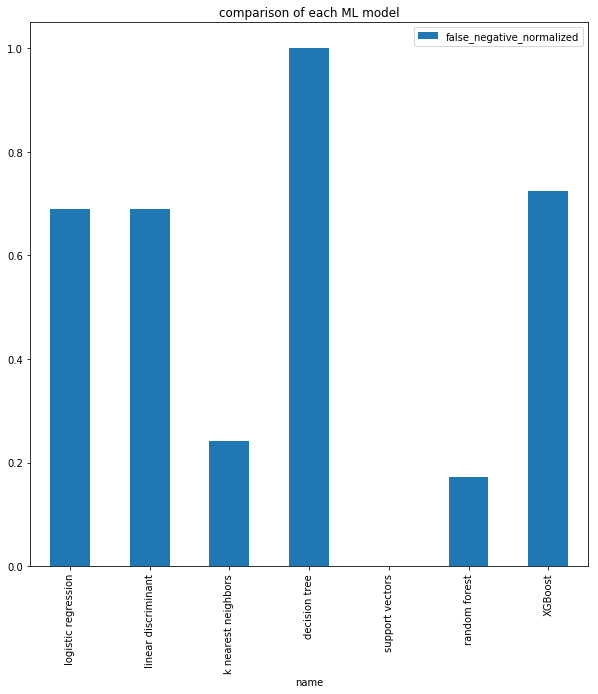

In [47]:
model_viz = blah[['false_negative_normalized', 'fraud_precision', 'fraud_f1-score']].plot(kind='bar', title='comparison of each ML model', figsize=(10,10))

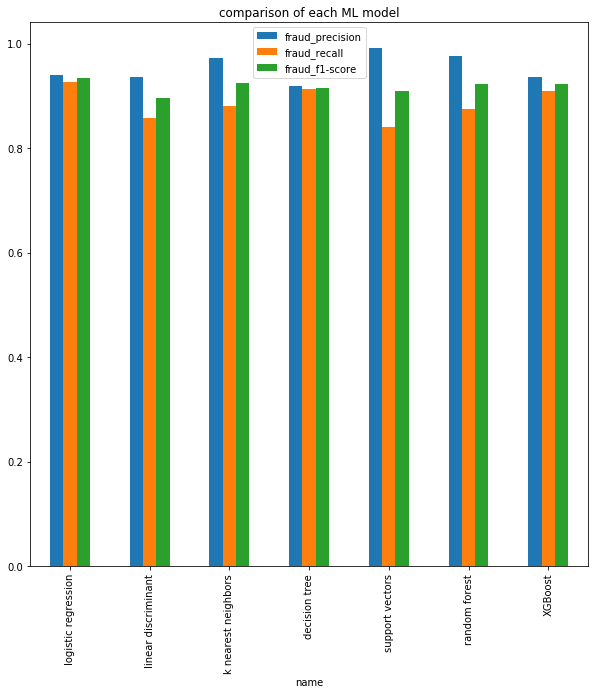

In [49]:
model_viz = blah[['fraud_precision', 'fraud_recall', 'fraud_f1-score']].plot(kind='bar', title='comparison of each ML model', figsize=(10,10))

In [45]:
results.to_pickle('./results/baseline.pkl')

## Undersampling write-up 